In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os

from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense,GlobalAveragePooling2D


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_rand():
    X=[]
    dir_path="./Practical7/dataset/train/"
    for sub_dir in tqdm(os.listdir(dir_path)):
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(224,224))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X

In [4]:
images_arr=np.array(load_rand())
images_arr.shape

100%|██████████| 6/6 [00:00<00:00, 41.56it/s]


(36, 224, 224, 3)

## Print number of images for each class

In [10]:
train_dir = "./Practical7/dataset/train/"
test_dir = "./Practical7/dataset/test/"

## Augment the data

In [8]:
datagen = ImageDataGenerator( 
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,                           
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )

datagen1 = ImageDataGenerator(
  rescale=1./255,                           
  preprocessing_function=keras.applications.vgg16.preprocess_input
  )

In [9]:
train_generator = datagen.flow_from_directory(train_dir, 
                                       target_size=[224,224],
                                       color_mode='rgb', 
                                       class_mode="categorical", 
                                       batch_size = 32, 
                                       shuffle=True) 
validation_generator = datagen1.flow_from_directory(test_dir, 
                                       target_size=[224,224],
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size = 32,
                                       shuffle=True) 

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
validation_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):

    conv_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    top_model = conv_base.output
    
    # Add Global Average pooling layer
    top_model = GlobalAveragePooling2D()(top_model)

    # Add output layer
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compile the model for training.
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (224, 224, 3)
n_classes=6

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, fine_tune=0)

In [ ]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Train the model

In [ ]:
checkpoint_filepath = 'vgg16_model_best_weights.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
vgg_history = vgg_model.fit(train_generator,validation_data=validation_generator,
          steps_per_epoch=train_generator.samples/train_generator.batch_size, 
          validation_steps=validation_generator.samples/validation_generator.batch_size, 
          epochs=20,callbacks=[checkpoint])

2023-02-03 21:24:28.529521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-03 21:24:32.008122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


340/340 [==============================] - 306s 845ms/step - loss: 1.1414 - accuracy: 0.6885 - val_loss: 0.7088 - val_accuracy: 0.8580

Epoch 00001: val_accuracy improved from -inf to 0.85804, saving model to vgg16_model_best_weights.h5
Epoch 2/20
340/340 [==============================] - 202s 593ms/step - loss: 0.6060 - accuracy: 0.8699 - val_loss: 0.4607 - val_accuracy: 0.8847

Epoch 00002: val_accuracy improved from 0.85804 to 0.88473, saving model to vgg16_model_best_weights.h5
Epoch 3/20
340/340 [==============================] - 202s 593ms/step - loss: 0.4304 - accuracy: 0.8973 - val_loss: 0.3492 - val_accuracy: 0.9199

Epoch 00003: val_accuracy improved from 0.88473 to 0.91994, saving model to vgg16_model_best_weights.h5
Epoch 4/20
340/340 [==============================] - 203s 597ms/step - loss: 0.3465 - accuracy: 0.9130 - val_loss: 0.2876 - val_accuracy: 0.9299

Epoch 00004: val_accuracy improved from 0.91994 to 0.92995, saving model to vgg16_model_best_weights.h5
Epoch 5/20

## Plot training and validation accuracy


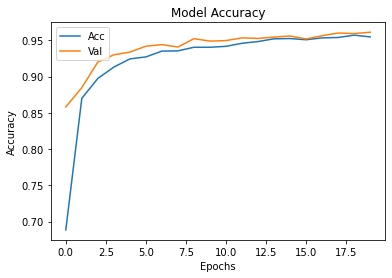

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')

## Plot training and validation error

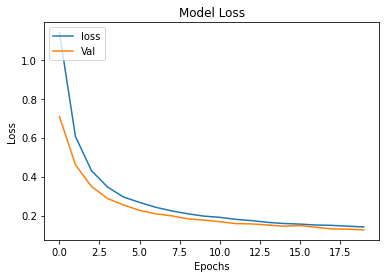

In [ ]:
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

# B: Apply transfer Learning to RESNET on fruits classification dataset

In [ ]:
# Load and prepare the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'train_dir', target_size=(224, 224), batch_size=32, class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'val_dir', target_size=(224, 224), batch_size=32, class_mode='categorical')

# Build the ResNet model
from keras.applications import ResNet50
from keras.layers import Dense, Flatten
from keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit_generator(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test_dir', target_size=(224, 224), batch_size=32, class_mode='categorical')

model.evaluate_generator(test_generator)
